Importation des packages

In [1]:
!pip install py7zr geojson geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-im_4ikb2
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-im_4ikb2
  Resolved https://github.com/inseefrlab/cartiflette to commit f6b0c5d049bd6dcae7b437bd931957371da24278
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geojson
import requests
import time
import os
import re
import magic
import matplotlib.pyplot as plt
import zipfile
import cartiflette
from io import StringIO

This is an experimental version of cartiflette published on PyPi.
To use the latest stable version, you can install it directly from GitHub with the following command:
pip install git+https://github.com/inseeFrLab/cartiflette.git


Description des variables de ce dataframe :
- idmutinvar = identifiant unique entre les diff bases pour retrouver chaque mutation
- idopendata = identifiant de mutation utilisé depuis l'ouverture de données DVF
- datemut = date de signature de l'acte de vente
- anneemut = annee de signature du doc
- codedep
- libnatmut = Libellé de nature de mutation tel que défini dans la donnée source DVF 6 catégories : Vente, Vente en l'état futur d'achèvement, Adjudication, Echange, Vente terrain à bâtir et Expropriation.
- vefa = booléen selon si la vente est en VEFA (vente en l'état futur d'achèvement) ou non
- valeurfonc = valeur foncière en euro déclarée lors de la vente ; prix net vendeur, inclut la TVA mais n'inclut pas les frais de notaire, d'agence ou des meubles. 
- nbcomm = nombre de communes concernée par la mutation (i.e. sur lesquelles se trouve la parcelle cadastrale concernée par la mutation)
- nbpar = comme nbcomm mais pour les parcelles.
- nbparmut = nb de parcelles ayant muté (i.e. dont la pleine propriété a été transférée lors de la mutation)
- sterr = surface de terrain ayant muté (mutation = transfert de propriété, donc surface de terrain ayant muté = surface du terrain qui a été vendu)
- nbvolmut = variable obscure, flemme 
- nblocmut = nb de locaux ayant muté
- sbati = surface de l'ensemble du bati ayant muté
- codtypbien = typologie des biens ; on pourra s'en servir pour filter les maisons et appartements et virer tous les types de batiments bizarres (cf schéma ici) https://doc-datafoncier.cerema.fr/doc/dv3f/mutation/codtypbien
- libtypbien = comme codtypbien mais pour la base DV3F et non issu de juste DVF
- geometry
- l_codeinsee = liste des codes INSEE des communes concernées par la mutation
- l_idpar =Liste des idpar qui composent l’entité (idpar = Identifiant de parcelle)
- l_idparmut = liste des identifiants de parcelles ayant muté (idpar)
- l_idlocmut = liste des identifiants de locaux ayant muté (idloc)

On veut d'abord récupérer les données de la base DVF à partir de l'API publique dédiée. On peut regarder la documentation de cette API sur le site suivant : 
https://apidf-preprod.cerema.fr/swagger/#/DVF%2B%20(acc%C3%A8s%20libre)/dvf_opendata_geomutations_list


I. Importation des données DVF

A. Paramétrage de l'API

In [3]:
def cleaning_json_for_gpd(data):
    for feature in data["features"]:
        properties = feature["properties"]
        for key, value in properties.items():
            if isinstance(value, list):  # Vérifie si c'est une liste
                properties[key] = ", ".join(map(str, value))  # Convertit en chaîne séparée par des virgules

In [4]:
def recup_donnees_dvf(code_insee,annee_mut):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?anneemut={annee_mut}&code_insee={code_insee}&page_size=300"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

In [5]:
def recup_donnees_dvf_all_years(code_insee):
        url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=500"
        response = requests.get(url)
        data = response.json()
        cleaning_json_for_gpd(data)
        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
        col_mut = mut_gdf_tempo.columns
        mut_gdf = gpd.GeoDataFrame(columns=col_mut)

        while url != None : 
                response = requests.get(url)
                if response.status_code == 200:
                        data = response.json()
                        url = data['next']
                        print(url)
                        cleaning_json_for_gpd(data) #transforme le dictionary qu'est data en un dataframe
                        mut_gdf_tempo = gpd.GeoDataFrame.from_features(data["features"])
                        mut_gdf = pd.concat([mut_gdf, mut_gdf_tempo], axis=0)
                    
                else:
                        print(f"Erreur : {response.status_code}")
                        url = None

        return mut_gdf

On écrit la racine de l'API : 

In [6]:
base_api_dvf_url = "https://apidf-preprod.cerema.fr"

On va récupérer les données DVF des villes suivantes : 
1. Zone ouest :
- Paris 16 : 75116
- Paris 17: 75117
- Clichy : 92024
- Levallois : 92044
- Neuilly : 92051
- Boulogne-Billancourt : 92012

2. Zone sud
- Paris 13 : 75113
- Paris 14 : 75114
- Paris 15 : 75115
- Issy-les-Moulineaux : 92040
- Vanves : 92075
- Malakoff : 92046
- Montrouge : 92049
- Gentilly : 94037
- Ivry-sur-Seine : 94041


On constate en faisant tourner naïvement l'API qu'on obtient toujours des données par paquets en nombre limité (par défaut, 100). On peut modifier cela par le paramètre "page_size", mais la limite est de 500. Pour un paramètre supérieur à 500, on n'obtient que des pages de 500. 

On cherche donc à faire boucler nos requêtes à l'API jusqu'à obtenir toutes les données concernant la commune qui nous intéresse. Or on constate que la réponse "data" que l'on obtient possède une clé "next", qui donne l'url de notre requête complété par un argument "page". L'API fonctionne donc ainsi : s'il y a plus de 500 observations pour une commune, l'API nous renvoie une première page qui contient 500 observations, avec l'url pour requêter la page suivant qui contient 500 autres observations, et ainsi de suite jusqu'à la dernière page, qui donne pour valeur "None" à la clé "next". 

Le code ci-dessous permet de récupérer les données.

In [7]:
"""data_dvf_sud = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_sud = ["92040", "92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [8]:
"""data_dvf_sud = recup_donnees_dvf_all_years("92040") 

code_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]
code_insee_arrond_sud = ["75113", "75114", "75115"]

for code_insee_ville in code_insee_ville_banlieue_sud: 
    print(code_insee_ville)
    data_temp = recup_donnees_dvf_all_years(code_insee_ville)
    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)

data_dvf_sud.shape"""

'data_dvf_sud = recup_donnees_dvf_all_years("92040") \n\ncode_insee_ville_banlieue_sud = ["92075", "92046", "92049", "94037", "94041"]\ncode_insee_arrond_sud = ["75113", "75114", "75115"]\n\nfor code_insee_ville in code_insee_ville_banlieue_sud: \n    print(code_insee_ville)\n    data_temp = recup_donnees_dvf_all_years(code_insee_ville)\n    data_dvf_sud = pd.concat([data_dvf_sud, data_temp], axis = 0)\n\ndata_dvf_sud.shape'

In [9]:
#data_dvf_sud.shape

Difficulté : l'API peut arrêter de nous répondre de manière imprévue au milieu de la boucle de requête des pages. Dans ce cas, toutes les données obtenues sur les pages précédentes sont perdues. On a donc intérêt, pour pouvoir travailler sereinement, à télécharger ces données. 

Pour ce faire, on va essayer, commune par commune, de requêter toutes les pages, et, AVANT de passer au requêtage pour la commune suivante, on sauvegarde notre geodataframe au format geojson. 

In [10]:
"""code_insee_pour_enregistre = ["92012"]
for code_insee in code_insee_pour_enregistre: 
    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"
    response = requests.get(url)
    data = response.json()
    print(data['count'])
    gdf = recup_donnees_dvf_all_years(code_insee)
    name = f'data/dvf/data_code_insee={code_insee}.geojson'
    gdf.to_file(name, driver="GeoJSON")
    gdf = gpd.read_file(name)
    print(len(gdf))"""

'code_insee_pour_enregistre = ["92012"]\nfor code_insee in code_insee_pour_enregistre: \n    url = base_api_dvf_url + f"/dvf_opendata/geomutations/?code_insee={code_insee}&page_size=100"\n    response = requests.get(url)\n    data = response.json()\n    print(data[\'count\'])\n    gdf = recup_donnees_dvf_all_years(code_insee)\n    name = f\'data/dvf/data_code_insee={code_insee}.geojson\'\n    gdf.to_file(name, driver="GeoJSON")\n    gdf = gpd.read_file(name)\n    print(len(gdf))'

On fait pareil pour la zone ouest de Paris

In [11]:
"""data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) 

code_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]

for code_insee_ville in code_insee_ville_banlieue_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)

data_dvf_ouest_banlieue.shape"""

'data_dvf_ouest_banlieue = recup_donnees_dvf("92040",2014) \n\ncode_insee_ville_banlieue_ouest = ["92040", "92075", "92046", "92049", "94037", "94041"]\n\nfor code_insee_ville in code_insee_ville_banlieue_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest = pd.concat([data_dvf_ouest, data_temp], axis = 0)\n\ndata_dvf_ouest_banlieue.shape'

In [12]:
"""data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)

code_insee_arrond_ouest = ["75116", "75117"]

for code_insee_ville in code_insee_arrond_ouest: 
    print(code_insee_ville)
    for annee in range(2013,2022):
        print(annee)
        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))
        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)
"""

'data_dvf_ouest_paris = recup_donnees_dvf("75116",2012)\n\ncode_insee_arrond_ouest = ["75116", "75117"]\n\nfor code_insee_ville in code_insee_arrond_ouest: \n    print(code_insee_ville)\n    for annee in range(2013,2022):\n        print(annee)\n        data_temp = recup_donnees_dvf(code_insee_ville,str(annee))\n        data_dvf_ouest_paris = pd.concat([data_dvf_ouest_paris, data_temp], axis = 0)\n'

Ci-dessous, le code pour reconstituer les fichiers geojson à partir des sauvegardes faites à cause de l'API défectueuse (en deux temps : la zone ouest puis la zone sud)

In [13]:
obs_tot = 0
list_gpd_ouest = []
for geo_file in os.listdir("data/dvf/cluster_ouest"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_ouest/"+geo_file)  
    list_gpd_ouest.append(geo_file_temp)
    obs_tot += len(geo_file_temp)

all_gpd_ouest = pd.concat(list_gpd_ouest)
print(len(all_gpd_ouest), obs_tot)

134410 134410


In [14]:
obs_tot = 0
list_gpd_sud = []
for geo_file in os.listdir("data/dvf/cluster_sud"): 
    geo_file_temp = gpd.read_file("data/dvf/cluster_sud/"+geo_file)  
    obs_tot += len(geo_file_temp)
    list_gpd_sud.append(geo_file_temp)

all_gpd_sud = pd.concat(list_gpd_sud)
print(len(all_gpd_sud), obs_tot)

119319 119319


II. Récupération de données Insee par IRIS pour avoir des variables de contrôle dans notre régression

Il n'y a pas d'API permettant de récupérer les données voulues par IRIS, donc on doit passer par l'importation de tous les fichiers. On importe trois types de fichiers : un qui contient des informations sur le revenu disponible ('BASE_TD_FILO_DISP_IRIS), un qui donne des informations sur les logements ('base_ic_logement') et un sur les occupations professionnelles des habitants de l'IRIS ('base-ic-activite-residents').

In [15]:
dfs_activite = []
dfs_logement = []
dfs_revenu = []
dates_df = []


for f in os.listdir("data/insee"):
    if f.lower().endswith(".zip"): #si c'est un zip
        print(f)
        zip_file = zipfile.ZipFile("data/insee/"+f) #on le dézipe
        nom_racine_dossier = f.rsplit(".",1)[0]
        for f_in_zip in zipfile.ZipFile("data/insee/"+f).namelist():
            if f_in_zip[0:4] == "meta" :
                pass
            else :
                nom_racine_fichier = f_in_zip.rsplit(".",1)[0]
                extension = f_in_zip.rsplit(".",1)[1] #on récupère l'extension
                
                # Recherche de l'année
                schema_date = r"(\d{4})"
                match = re.search(schema_date, f)
                    
                annee_extraite = match.group(1)
                
                if extension.lower() == "csv":
                    df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension), 
                                            sep = ";", dtype = {'IRIS' : str})
                                            
                elif extension in ("xls", "xlsx"):
                    df_temp = pd.read_excel(zip_file.open(nom_racine_fichier + "." + extension),
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
                df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
                
                deux_derniers_chiffres_annee = annee_extraite[2:4]
                df_temp['annee'] = annee_extraite
                
                if "activite" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_activite.append(df_temp)
                elif "logement" in nom_racine_fichier:
                    df_temp.columns = [col.replace(f'{deux_derniers_chiffres_annee}_', '_') for col in df_temp.columns]
                    dfs_logement.append(df_temp)
                elif "DISP" in nom_racine_fichier:
                    colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
                    df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
                    dfs_revenu.append(df_temp)
                else :
                    print('un fichier n a pas été traité')

                dates_df.append(annee_extraite)
    else :
        nom_racine_fichier = f.rsplit(".",1)[0]
        extension = f.rsplit(".",1)[1] #on récupère l'extension
                
        schema_date = r"(\d{4})"
        match = re.search(schema_date, f)     
        annee_extraite = match.group(1)

        df_temp = pd.read_excel("data/insee/" + nom_racine_fichier + "." + extension,
                                            skiprows = 5, dtype = {'IRIS' : str})
                    
        df_temp['IRIS'] = df_temp['IRIS'].apply(lambda x: '0' + x if len(x) == 8 else x)
        deux_derniers_chiffres_annee = annee_extraite[2:4]
        df_temp['annee'] = annee_extraite
                
        if "DISP" in nom_racine_fichier:
            colonnes_a_traiter = [col for col in df_temp.columns if col.endswith(deux_derniers_chiffres_annee)]
            df_temp = df_temp.rename(columns={col: col[:-2] for col in colonnes_a_traiter})
            dfs_revenu.append(df_temp)

        dates_df.append(annee_extraite)


base-ic-logement-2018_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2015.zip
base-ic-activite-residents-2021_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2018.zip
base-ic-activite-residents-2015.zip
base-ic-logement-2016.zip
base-ic-logement-2017_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2020_CSV.zip
base-ic-activite-residents-2019_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2020_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2016.zip
base-ic-logement-2019_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4,81,82,83,84,85,86,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2017_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-activite-residents-2018_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2020_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


base-ic-logement-2014.zip
base-ic-logement-2021_csv.zip


/tmp/ipykernel_72607/2103325727.py:26: DtypeWarning: Columns (1,3,80,81,82,83,84,85,90,91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(zip_file.open(nom_racine_fichier + "." + extension),


BASE_TD_FILO_DISP_IRIS_2019.zip
BASE_TD_FILO_IRIS_2021_DISP_CSV.zip
base-ic-activite-residents-2014.zip
BASE_TD_FILO_DISP_IRIS_2020_XLSX.zip


In [16]:
dfs_clean_activite = pd.concat(dfs_activite, ignore_index = True)
dfs_clean_revenu = pd.concat(dfs_revenu, ignore_index = True)
dfs_clean_logement = pd.concat(dfs_logement, ignore_index = True)

In [17]:
print(dfs_clean_activite.shape)
print(dfs_clean_revenu.shape)
print(dfs_clean_logement.shape)


(395824, 131)
(122018, 36)
(395824, 123)


In [18]:
df_fusion_inter = pd.merge(dfs_clean_activite, dfs_clean_revenu,how = "outer", on=['IRIS','annee']) 
df_fusion_all_insee = pd.merge(df_fusion_inter, dfs_clean_logement, how = "outer",on=['IRIS', 'annee'])#, 'LIBIRIS','TYP_IRIS','MODIF_IRIS','LAB_IRIS','COM', 'LIBCOM'])

Vérifions que le dataframe obtenu n'a pas de problème.

In [19]:
print(df_fusion_inter.shape)
print(df_fusion_all_insee.shape)

(411921, 165)
(411921, 286)


III. Fusion de nos deux jeux de données


Troisième et dernière étape d'importation des données : un fichier pour faire la correspondance entre les adresses/coordonnées des données DVF et les IRIS des données Insee.

On utilise un fichier des données géographiques des IRIS d'Île-de-France.

In [20]:
iris = gpd.read_file("data/iris.geojson")  
iris = iris.to_crs(epsg=4326)  # Assurez-vous d'utiliser le même système de coordonnées (WGS84)
iris['code_iris'] = iris['code_iris'].astype(str)

On regarde dans quel système géographique est le tableau geopandas des données DVF

In [21]:
print(all_gpd_sud["geometry"].crs)
print(all_gpd_ouest["geometry"].crs)

EPSG:4326
EPSG:4326


Ok, on est bien en format 4326 (=WGS 84) pour les deux fichiers, on va pouvoir affecter des IRIS à nos adresses de la base DVF (pour ensuite relier ça aux fichiers Insee)

In [22]:
data_mut_sud_avec_iris = gpd.sjoin(all_gpd_sud, iris, how="left", predicate="intersects")
data_mut_ouest_avec_iris = gpd.sjoin(all_gpd_ouest, iris, how="left", predicate="intersects")

# Vérifier les résultats
print(data_mut_sud_avec_iris.head())
print(data_mut_sud_avec_iris.columns)
print(all_gpd_sud.shape)
print(data_mut_sud_avec_iris.shape)

                         idmutinvar                        idopendata  \
0  95a6760ed10c9de595b655e8f1db703f  95a6760ed10c9de595b655e8f1db703f   
1  4a37e862dcb628c7b473b474b6dbb3ed  4a37e862dcb628c7b473b474b6dbb3ed   
2  9711e8d4ccc5c4dfa867545f65cc28c3  9711e8d4ccc5c4dfa867545f65cc28c3   
3  ff355bdd9fdf67cc54c7d4e90bad115d  ff355bdd9fdf67cc54c7d4e90bad115d   
4  14b9a2c07cfe462e0a6a34bc3f87b6eb  14b9a2c07cfe462e0a6a34bc3f87b6eb   

     datemut anneemut coddep libnatmut   vefa valeurfonc nbcomm l_codinsee  \
0 2024-05-14     2024     92     Vente  False   38000.00      1      92049   
1 2024-02-26     2024     92     Vente  False   18000.00      1      92049   
2 2024-03-19     2024     92     Vente  False  220000.00      1      92049   
3 2024-05-27     2024     92     Vente  False  518000.00      1      92049   
4 2024-06-04     2024     92     Vente  False  540000.00      1      92049   

   ...                                           geometry index_right  \
0  ...  MULTIPOLYGO

Les deux codes ci-dessous servent à éliminer les ventes qui sont à cheval entre deux IRIS (on a assez d'observations comme ça et elles pourraient brouiller les résultats de la régression).

In [23]:
non_unique_ids_sud = data_mut_sud_avec_iris['idmutinvar'][data_mut_sud_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_sud_avec_iris_unique = data_mut_sud_avec_iris[~data_mut_sud_avec_iris['idmutinvar'].isin(non_unique_ids_sud)]
data_mut_sud_avec_iris = data_mut_sud_avec_iris_unique

In [24]:
non_unique_ids_ouest = data_mut_ouest_avec_iris['idmutinvar'][data_mut_ouest_avec_iris['idmutinvar'].duplicated(keep=False)]
data_mut_ouest_avec_iris_unique = data_mut_ouest_avec_iris[~data_mut_ouest_avec_iris['idmutinvar'].isin(non_unique_ids_ouest)]
print(data_mut_ouest_avec_iris.shape)
print(data_mut_ouest_avec_iris_unique.shape)

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris_unique

(140041, 31)
(129306, 31)


On enlève les ventes faites après 2021 car les données Insee s'arrêtent en 2021

In [25]:
data_mut_sud_avec_iris = data_mut_sud_avec_iris[data_mut_sud_avec_iris['anneemut'].astype(int) < 2022]
data_mut_sud_avec_iris.shape

data_mut_ouest_avec_iris = data_mut_ouest_avec_iris[data_mut_ouest_avec_iris['anneemut'].astype(int) < 2022]
data_mut_ouest_avec_iris.shape

(96924, 31)

Dernière étape : relier ça aux données Insee

In [44]:
data_mut_ouest_et_insee = pd.merge(left = data_mut_ouest_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])

data_mut_sud_et_insee = pd.merge(left = data_mut_sud_avec_iris,
                            right = df_fusion_all_insee, 
                            how = "inner",
                            left_on = ["code_iris", "anneemut"],
                            right_on = ["IRIS", "annee"])
                            

In [27]:
data_mut_ouest_et_insee.shape

(109677, 317)

Ci-dessous, on va regarder les variables des trois jeux de données Insee et vérifier qu'ils sont bien présents dans le jeu de données final (on va regarder sur 2019 car on sait qu'il y a bien pour cette année des données DVF et Insee complètes)

In [28]:
data_mut_ouest_et_insee_2019 = data_mut_ouest_et_insee[data_mut_ouest_et_insee["anneemut"] == "2019"]

In [29]:
dfs_revenu[1].columns

Index(['IRIS', 'DISP_TP60', 'DISP_Q1', 'DISP_MED', 'DISP_Q3', 'DISP_EQ',
       'DISP_D1', 'DISP_D2', 'DISP_D3', 'DISP_D4', 'DISP_D6', 'DISP_D7',
       'DISP_D8', 'DISP_D9', 'DISP_RD', 'DISP_S80S20', 'DISP_GI', 'DISP_PACT',
       'DISP_PTSA', 'DISP_PCHO', 'DISP_PBEN', 'DISP_PPEN', 'DISP_PPAT',
       'DISP_PPSOC', 'DISP_PPFAM', 'DISP_PPMINI', 'DISP_PPLOGT', 'DISP_PIMPOT',
       'DISP_NOTE', 'annee'],
      dtype='object')

In [30]:
dfs_logement[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_RP_TTEGOU', 'P_RP_GARL', 'P_RP_VOIT1P', 'P_RP_VOIT1', 'P_RP_VOIT2P',
       'P_RP_HABFOR', 'P_RP_CASE', 'P_RP_MIBOIS', 'P_RP_MIDUR', 'annee'],
      dtype='object', length=103)

In [31]:
dfs_activite[1].columns

Index(['IRIS', 'REG', 'DEP', 'UU2010', 'COM', 'LIBCOM', 'TRIRIS', 'GRD_QUART',
       'LIBIRIS', 'TYP_IRIS',
       ...
       'P_ACTOCC15P_ILT3', 'P_ACTOCC15P_ILT4', 'P_ACTOCC15P_ILT5',
       'C_ACTOCC15P', 'C_ACTOCC15P_PAS', 'C_ACTOCC15P_MAR', 'C_ACTOCC15P_DROU',
       'C_ACTOCC15P_VOIT', 'C_ACTOCC15P_TCOM', 'annee'],
      dtype='object', length=115)

In [32]:
print(data_mut_ouest_et_insee_2019['P_ACTOCC15P_ILT3']) #activite
print(data_mut_ouest_et_insee_2019['P_RP_VOIT1P']) #logement
print(data_mut_ouest_et_insee_2019['DISP_D1']) #revenu

10177      405.725596
10178      488.261079
10179      345.759051
10180      341.388668
10181      428.201811
             ...     
104325     392.985318
104326     782.718335
104327    1102.075466
104328     728.812234
104329    1102.075466
Name: P_ACTOCC15P_ILT3, Length: 15282, dtype: float64
10177     426.731153
10178     608.133911
10179     426.768578
10180     512.641276
10181     831.140647
             ...    
104325    470.856413
104326    822.214108
104327    837.176285
104328    841.889822
104329    837.176285
Name: P_RP_VOIT1P, Length: 15282, dtype: float64
10177     12290
10178     13460
10179     15270
10180     14240
10181     15680
          ...  
104325    11050
104326    14560
104327    14760
104328    14810
104329    14760
Name: DISP_D1, Length: 15282, dtype: object


IV. Nettoyage du jeu de données

Regardons d'abord notre jeu de données :

In [33]:
print(data_mut_ouest_et_insee.shape)

(109677, 317)


On a énormément de colonnes dans ce jeu de données, sont-elles toutes utilisables ?

In [34]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee)) 
print(df_verif)

                         0
idmutinvar        0.000000
idopendata        0.000000
datemut           0.000000
anneemut          0.000000
coddep            0.000000
...                    ...
P_RPMAISON_ACH11  0.895940
P_RPAPPART_ACH11  0.895940
P_RP_ACH18        0.868268
P_RPMAISON_ACH18  0.868268
P_RPAPPART_ACH18  0.868268

[317 rows x 1 columns]


Visiblement, certaines colonnes sont presque vides (on affiche ici le pourcentage d'observations manquantes). On va supprimer toutes les colonnes qui ont plus de 10% d'observations manquantes.

In [35]:
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_ouest_et_insee = data_mut_ouest_et_insee.drop(to_drop, axis=1)
print(data_mut_ouest_et_insee.shape)

(109677, 237)


Vérifions qu'on a bien enlevé toutes les colonnes vides : 

In [36]:
df_verif = pd.DataFrame(data_mut_ouest_et_insee.isna().sum() / len(data_mut_ouest_et_insee))
df_to_drop = df_verif[df_verif[0] > 0.1]
print(df_to_drop.shape)

(0, 1)


Vérifions aussi que nous avons conservé les variables qui nous intéressaient le plus dans les jeux de données INSEE :

In [37]:
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)

False
False
False


Maintenant qu'on a épuré les colonnes, on peut regarder les lignes. Il faut enlever toutes les transactions qui ne nous intéressent pas. En particulier, certaines transactions affichent une surface batie vendue de 0 ET une surface de terrain vendue de 0. D'autres transactions présentent une valeur de vente de 0. 

In [38]:
df_ouest = data_mut_ouest_et_insee
df_ouest['valeurfonc']  = df_ouest["valeurfonc"].astype(float)
df_ouest['sbati']  = df_ouest["sbati"].astype(float)
df_ouest['sterr']  = df_ouest["sterr"].astype(float)
df_ouest['stot']  = df_ouest["sterr"] + df_ouest["sbati"]


In [39]:
print(len(df_ouest))
df_ouest = df_ouest[df_ouest['stot']>0]
df_ouest = df_ouest[df_ouest['valeurfonc']>0]
print(len(df_ouest))

109677
89989


On va également s'assurer que les transactions ne concernent que des maisons ou des appartements (voire la documentation).

In [40]:
df_ouest = df_ouest[df_ouest["codtypbien"].str.startswith(('11', "12"))]
print(len(df_ouest))

83030


In [48]:
biens_retenus = ['UN APPARTEMENT', 'UNE MAISON']
df_ouest = df_ouest[df_ouest['libtypbien'].isin(biens_retenus)]
print(len(df_ouest))

77753


In [41]:
data_mut_ouest_et_insee = df_ouest

On va répéter exactement la même chose pour la zone sud : 

In [ ]:
print(data_mut_sud_et_insee.shape)
df_sud = data_mut_sud_et_insee
df_verif = pd.DataFrame(data_mut_sud_et_insee.isna().sum() / len(data_mut_sud_et_insee)) 
df_to_drop = df_verif[df_verif[0] > 0.1]
to_drop = []
for index, row in df_to_drop.iterrows():
    to_drop.append(index)
data_mut_sud_et_insee = data_mut_sud_et_insee.drop(to_drop, axis=1)
df_sud = data_mut_sud_et_insee
print('P_ACTOCC15P_ILT3' in to_drop)
print('P_RP_VOIT1P' in to_drop)
print('DISP_D1' in to_drop)
df_sud['valeurfonc']  = df_sud["valeurfonc"].astype(float)
df_sud['sbati']  = df_sud["sbati"].astype(float)
df_sud['sterr']  = df_sud["sterr"].astype(float)
df_sud['stot']  = df_sud["sterr"] + df_ouest["sbati"]
df_sud = df_sud[(df_sud['stot']>0) & (df_sud['valeurfonc']>0)]
df_sud = df_sud[df_sud["codtypbien"].str.startswith(('11', "12"))]
df_sud = df_sud[df_sud['libtypbien'].isin(biens_retenus)]
data_mut_sud_et_insee = df_sud
print(data_mut_sud_et_insee.shape)

(95139, 317)
False
False
False
(56467, 238)


V. Visualisation

On commence à faire vite-fait un peu de visualisation spatiale

NameError: name 'data_mut_et_insee' is not defined

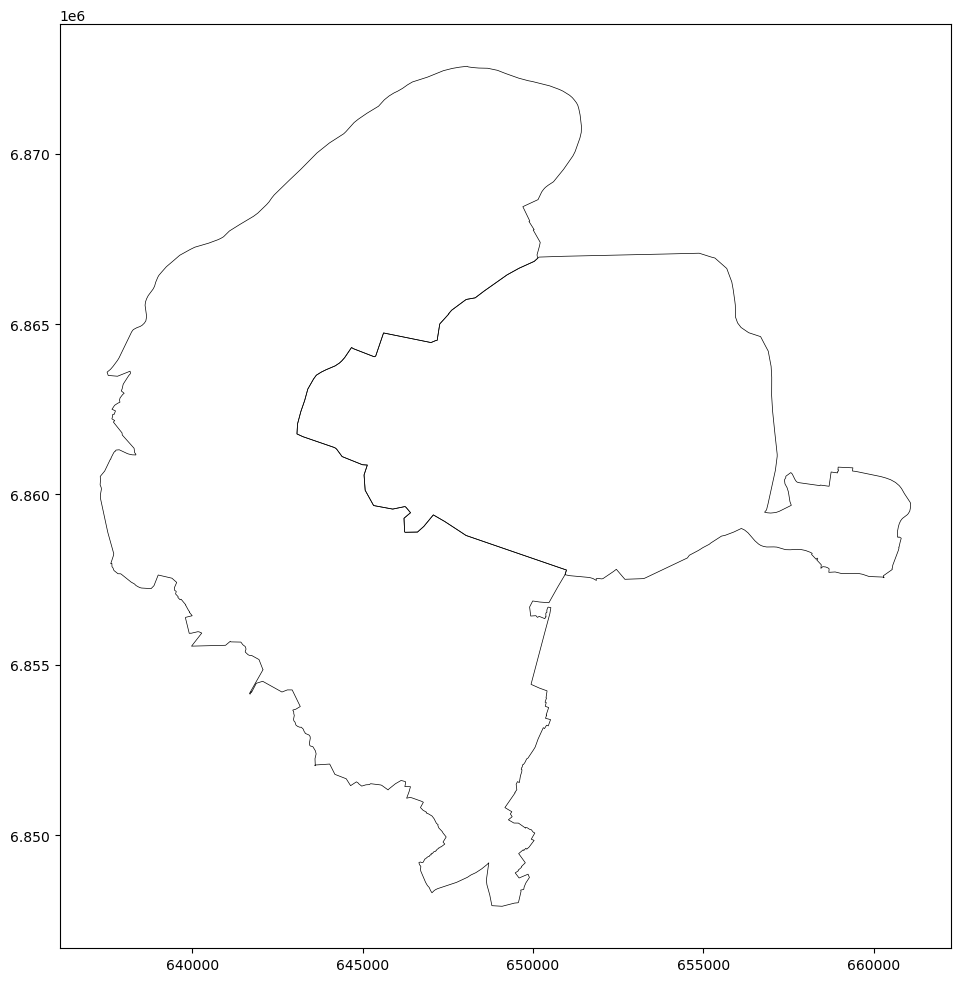

In [43]:
idf = cartiflette.carti_download(
    values=["11"],
    crs=4326,
    borders="DEPARTEMENT",
    vectorfile_format="geojson",
    filter_by="REGION",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

departements_paris_92 = idf.loc[
    idf["INSEE_DEP"].isin(["75", "92"])
].to_crs(2154)

fig, ax = plt.subplots(figsize=(12, 12))
base = departements_paris_92.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, figsize=(10, 10))

data_mut_et_insee_pour_vis = data_mut_et_insee
data_mut_et_insee_pour_vis["geometry"] = data_mut_et_insee_pour_vis["geometry"].to_crs(2154)

data_mut_et_insee_pour_vis.plot(ax=ax)

plt.show()



On a sélectionné ici au début du code les villes de Vanves et Issy les Moulineaux, d'où le fait que les tâches de couleur s'affichent sur une zone localisée (uniquement les villes concernées)
= > il faudra ajuster l'API et le fond de carte selon la commune choisie, mais au moins on sait le faire fonctionner grosso modo

V. Differences in differences

On cherche à appliquer ce modèle à deux ensembles : l'Ouest parisien et le Sud parisien. Dans chaque ensemble, on établit un groupe "contrôle" (villes en bordures du périphérique) et un groupe "traitement" (arrondissements parisiens en bordure du périphérique). 

In [ ]:
crtl_sud = data_mut_ouest_et_insee[data_mut_ouest_et_insee['l']]

109677

In [ ]:
data_mut_ouest_et_insee['l_codinsee']

0         75117
1         75117
2         75117
3         75117
4         75117
          ...  
109672    92044
109673    92044
109674    92044
109675    92044
109676    92044
Name: l_codinsee, Length: 109677, dtype: object